In [1]:
# Modules

import numpy as np
import scipy as sp
import scipy.integrate as spint
import matplotlib.pyplot as plt

import matplotlib.ticker as ticker

from joblib import Parallel, delayed

In [2]:
# Class for the model

class cann_model:
    # define the range of perferred stimuli
    z_min = - np.pi;              
    z_range = 2.0 * np.pi;
    # define the time scale
    tau = 10.0
    
    tau1 = 50.0
    tau2 = 500.0
        
    # function for periodic boundary condition
    def dist(self, c):
        tmp = np.remainder(c, self.z_range)
        
        # routine for numbers
        if isinstance(tmp, (int, float)):
            if tmp > (0.5 * self.z_range):
                return (tmp - self.z_range);
            return tmp;
        
        # routine for numpy arraies
        for tmp_1 in np.nditer(tmp, op_flags=['readwrite']):
            if tmp_1 > (0.5 * self.z_range):
                tmp_1[...] = tmp_1 - self.z_range;
        
        return tmp;
    
    # constructor (?)
    def __init__(self, argument):
        self.k = argument.get("k", 0.5);         # rescaled inhibition
        self.a = argument.get("a", 0.5);         # range of excitatory connection
        self.N = argument.get("N", 200);         # number of units / neurons
        self.alpha = argument.get("alpha", 5); # range of excitatory connection
        self.beta = argument.get("beta", 5);   # number of units / neurons
        self.A = argument.get("A", 0);    # size of stimulus 
        self.dx = self.z_range / self.N     # separation between neurons
        
        # define perferred stimuli for each neuron
        self.x = (np.arange(0,self.N,1)+0.5) * self.dx + self.z_min;
        
        # calculate the excitatory couple for each pair of neurons
        self.Jxx = np.zeros((self.N, self.N));
        for i in range(self.Jxx.shape[0]):
            for j in range(self.Jxx.shape[1]):
                self.Jxx[i][j] = \
                np.exp(-0.5 * np.square(self.dist(self.x[i] \
                                                  - self.x[j]) / self.a)) \
                / (np.sqrt(2*np.pi) * self.a);
                
        self.y = np.zeros((self.N)*3);    # initialize neuronal inputs
        self.r = np.zeros((self.N));    # initialize neuronal activities
        self.input = np.zeros((self.N));    # initialial the external input
    
    # function for setting external iput for each neuron
    def set_input(self, A, z0):
        self.input = \
        A * np.exp(-0.25 * np.square(self.dist(self.x - z0) / self.a));
    
    # function for calculation of neuronal activity of each neuron
    def cal_r_or_u(self, y):
        u = y[0:self.N]
        u0 = 0.5 * (u + np.abs(u));
        r = np.square(u0);
        B = 1.0 + 0.125 * self.k * np.sum(r) * self.dx \
        / (np.sqrt(2*np.pi) * self.a);
        r = r / B;
        return r;
    
    # calculate the centre of mass of u
    def cm_of_u(self, y):
        u = y[0:self.N]
        max_i = u.argmax()
        cm = np.dot(self.dist(self.x - self.x[max_i]), u) / np.sum(u)
        cm = cm + self.x[max_i]
        return cm;
    
    # function of r driving S
    @staticmethod
    def func_S(r):
        sigma = 2
        loc = 6.0
        return sp.stats.norm.cdf(r, loc=loc, scale=sigma)
    
    # function of r driving Q
    @staticmethod
    def func_Q(r):
        sigma = 0.5
        mode = 1.0
        mu = np.log(mode) + sigma ** 2
        return sp.stats.lognorm.pdf(r, sigma, scale=np.exp(mu))
    
    # function for calculation of derivatives
    def get_dydt(self, t, y):
        u = y[self.N*0:self.N*1]
        S = y[self.N*1:self.N*2]
        Q = y[self.N*2:self.N*3]
        
        r = self.cal_r_or_u(u)
        
        I_tot = np.dot(self.Jxx, r) * self.dx + self.input
        
        dudt = \
        -u + (1+S)*(I_tot);
        
        dSdt = -S / self.tau1 + self.alpha * Q * self.func_S(r)
        
        dQdt = -Q / self.tau2 - self.alpha * Q * self.func_S(r) + self.beta * (1-Q) * self.func_Q(I_tot)
        
        dudt = dudt / self.tau;
        
        return np.concatenate((dudt, dSdt, dQdt))
    
    # function for calculation of derivatives
    def get_dydt_sym(self, t, y):
        u = y[self.N*0:self.N*1]
        S = y[self.N*1:self.N*2]
        Q = y[self.N*2:self.N*3]
        
        u = 0.5 * (u + u[::-1])
        
        r = self.cal_r_or_u(u)
        
        I_tot = np.dot(self.Jxx, r) * self.dx + self.input
        
        dudt = \
        -u + (1+S)*(I_tot);
        
        dSdt = -S / self.tau1 + self.alpha * Q * self.func_S(r)
        
        dQdt = -Q / self.tau2 - self.alpha * Q * self.func_S(r) + self.beta * (1-Q) * self.func_Q(I_tot)
        
        dudt = dudt / self.tau;
        
        return np.concatenate((dudt, dSdt, dQdt))
        

In [3]:

def one_sim(alpha = 1e-20, beta = 1e-20):
    arg = {}

    arg["k"] = 0.5
    arg["a"] = 0.5
    arg["N"] = 200
    arg["A"] = 2
    arg["z0"] = 1

    arg["alpha"] = alpha
    arg["beta"] = beta

    # construct a CANN object
    cann = cann_model(arg)
    
    # setting up an initial condition of neuronal inputs 
    # so that tracking can be reasonabl for small A and k < 1
    if arg["k"] < 1.0:
        cann.set_input(np.sqrt(32.0)/arg["k"], 0)
    else:
        cann.set_input(np.sqrt(32.0), 0)
    cann.y[0:cann.N] = cann.input
#    cann.y[0:cann.N] = np.zeros(cann.N)

    # setting up an external input according to the inputted parameter
    cann.set_input(arg["A"], 0)

    # run the simulation for 100 tau to initialize the network state
    # before the shift of the external input
    out = spint.solve_ivp(cann.get_dydt, (0, 100), cann.y, method="RK45");

    # setting up an external input according to the inputted parameter
    cann.set_input(0, 0)

    # run the simulation for 100 tau to initialize the network state
    # before the shift of the external input
    
    for t in range(100):
        out = spint.solve_ivp(cann.get_dydt, (0, 10), cann.y, method="RK45");
        cann.y = out.y[:,-1]
        cann.y[0:cann.N] = np.roll(cann.y[0:cann.N], 1)

    # setting up an external input according to the inputted parameter
    cann.set_input(0, 0)
        
    out = spint.solve_ivp(cann.get_dydt, (0, 2000), cann.y, method="RK45");

    # take a initial snapshot
    snapshots = np.array([cann.y])
    snapshots_cm = [cann.cm_of_u(cann.y)]
    
    t_step = 1
    
    # run the simulation and take snapshots every 10 taus
    for t in range(0,50,t_step):
        # decide the period of this step
        t0 = t
        t1 = t + t_step
        # run the simulation and update the state in the CANN object
        out = spint.solve_ivp(cann.get_dydt, (t0, t1), cann.y, method="RK45");
        cann.y = out.y[:,-1]
        # store the snapshot
        snapshots = np.append(snapshots, [cann.y.transpose()], axis=0)
        snapshots_cm.append(cann.cm_of_u(cann.y))
        # if the center of mass of the neuronal input is close to 
        # the destination, simulation terminates.
        # if np.abs(cann.cm_of_u(cann.y) - arg["z0"]) < (0.05):
        #     break;
        
    snapshots_cm = np.array(snapshots_cm)
        
    d = np.abs(np.sum(cann.dist(snapshots_cm[1:] - snapshots_cm[:(snapshots_cm.shape[0]-1)])))
        
    return d / t_step

    

In [4]:
alpha = np.arange(1e-20, 0.20001, 0.001)
beta = np.arange(1e-20, 0.20001, 0.001)
    
all_result = Parallel(n_jobs=-1)(delayed(one_sim)(alpha_i, beta_i) for beta_i in beta for alpha_i in alpha)
        
all_result = np.array(all_result).reshape((beta.shape[0],alpha.shape[0]))

np.save("v_int", all_result)

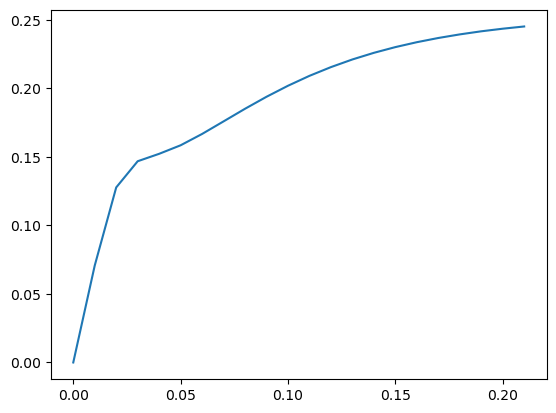

In [5]:
plt.plot(alpha, all_result[1,:])

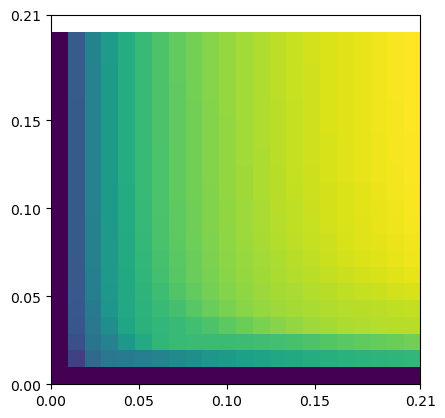

In [7]:
fig = plt.figure()

ax = fig.add_subplot()

ax.set_xticks((0,0.05,0.1,0.15,0.2))

ax.set_xlim((0,0.2))

ax.set_yticks((0,0.05,0.1,0.15,0.2))

ax.set_ylim((0,0.2))

extent=(np.min(alpha), np.max(alpha), np.min(beta), np.max(beta))

heatmap = ax.imshow(all_result[::-1], extent=extent)